# Generating plots for different algorithms

In [1]:
from stable_baselines3 import PPO, DQN, A2C, SAC
import numpy as np
import pandas as pd
from meal_planning_environment import MaxNutritionEnv, HeuristicEnv, GPTOnlyEnv, RLHFEnv
from meal_planning_environment import run_with_learning_algorithm
from dietkit import load_ingredient, load_menu, load_diet

import os 
import time
import sqlite3

2023-04-23 18:25:11.619679: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Initialize dietkit

In [2]:
all_ingredients = load_ingredient(sample_language = 'eng')
meal_dict = load_menu(ingredients = all_ingredients, sample_language = 'eng')
example_mealplans = load_diet(menus = meal_dict, num_loads = 100, sample_language = 'eng', sample_name = 'ML')

possible_meals = np.array(list(meal_dict.keys()))
meal_categories = np.array([meal.category if isinstance(meal.category, str) else meal.category[0] for meal in meal_dict.values()])
nutrition_data = pd.DataFrame([meal.nutrition for meal in meal_dict.values()], index=possible_meals)

display(possible_meals)
display(nutrition_data)

array(['S watermelon punch (without milks)', 'Dried persimmon',
       'S kyogo grape (100g)', ..., 'Green onion kimchi',
       'Pickled paprika', 'empty'], dtype='<U72')

,Energy,Protein,Fat,Carbohydrate,Total Dietary,Calcium,Iron,Sodium,Vitamin A,Vitamin B1 (Thiamine),Vitamin B2 (Rivoflavin),Vitamin C,Linoleic Acid,Alpha-Linolenic Acid
S watermelon punch (without milks),55.00,0.7900,0.05000,13.8180,0.200,7.200,0.18600,0.600,71.083333,0.024000,0.03000,0.0000,14.2500,2.9300
Dried persimmon,76.50,0.5820,0.04800,20.5830,3.360,6.300,0.19200,0.900,13.725000,0.003000,0.06720,1.5330,0.0000,8.6010
S kyogo grape (100g),61.00,0.4300,0.04000,16.3800,0.400,4.000,0.17000,1.000,2.166667,0.026000,0.04700,0.1300,11.8900,6.0900
S dried persimmon,85.60,0.7720,0.03200,22.9800,3.400,5.600,0.24800,0.400,9.533333,0.003600,0.09720,1.0680,0.0000,5.0440
S fruit punch,101.05,3.6700,3.36450,14.8900,0.790,117.650,0.19850,36.000,91.166667,0.040350,0.19110,1.8925,86.6605,10.6925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ponytail radish kimchi,10.25,0.5050,0.05000,1.9725,0.775,10.500,0.16750,173.000,5.541667,0.003250,0.01900,0.4125,19.7050,9.4775
Kohlrabi watery kimchi,5.50,0.2900,0.01250,1.2900,0.600,10.500,0.06750,1.750,0.250000,0.203750,0.00875,0.0000,1.9650,5.1100
Green onion kimchi,12.25,0.6250,0.14500,2.1275,1.150,15.000,0.18250,163.750,26.854167,0.012750,0.02850,0.5550,79.8050,17.1425
Pickled paprika,7.94,0.2017,0.03005,1.9859,0.348,1.675,0.08145,67.204,4.850000,0.003675,0.02709,24.2820,12.4483,6.5448


# Load carbon impact data

In [3]:
sql_conn = sqlite3.connect('carbon_impacts.db')
carbon_impacts_df = pd.read_sql_query("SELECT * FROM carbon_impacts", sql_conn)
carbon_impacts_df['meal'] = carbon_impacts_df['meal'].str.replace('Menu object: ', '')
display(carbon_impacts_df)
carbon_data = dict(zip(carbon_impacts_df.meal, carbon_impacts_df.impact))

,meal,impact,explanation
0,Dried persimmon,8.000000,The carbon impact score is 9. Drying persimmon...
1,S watermelon punch (without milks),-0.333333,The carbon impact score is -5. \n\nCarbonated ...
2,S kyogo grape (100g),4.000000,The carbon impact score is 6. Grapes have a re...
3,S dried persimmon,7.000000,The carbon impact score is 7. Dried persimmon ...
4,S fruit punch,-2.666667,The carbon impact score is -5. \n\nThis meal c...
...,...,...,...
3230,Ponytail radish kimchi,4.000000,The carbon impact score is 3. \n\nKimchi is ty...
3231,Kohlrabi watery kimchi,5.333333,The carbon impact score is 5. Kohlrabi is a lo...
3232,Green onion kimchi,3.333333,The carbon impact score is 2. \n\nKimchi and P...
3233,Pickled paprika,5.000000,The carbon impact score is 8. This meal has a ...


## Initialize MealPlanningEnv
Initialize each of the following environments:
1. MaxNutritionEnv
1. MaxNutritionCompositionEnv
2. HeuristicEnv
3. GPTOnlyEnv
4. RLHFEnv

Descriptions to write
-   Explaining the custom gym environment
    -   States, actions, observations, reward, agent
-   Explaining the custom random agent
-   Explaining the dataset
-   Explaining the heursitic reward function and nutrition values
-   Explaining the GPT warmup setup (RL"H"F)

Code to run/implement
-   Lucius (1 notebook): Demonstrating that the environment works (<PPO, DQN, A2C> + max nutrition reward)
-   Lucius (1 notebook): Demonstrating a better reward function (PPO + heuristic reward nutrition only)
-   Lucius (1 notebook): Demonstrating a better reward function (PPO + heuristic reward with some entropy/repetition)
-   Lucius (1 notebook): Demonstrating a better reward function (PPO + heuristic reward with (maybe entropy/repetition) + carbon impact)
-   Compare different algorithms for heuristic reward
-   Lucas (1 notebook): Compare different algorithms for GPT reward
-   Implement carbon impact in heuristic environment.
-   Lucas (functions/class in .py): Implement a new `plot_learning_curve()` function that takes in multiple directories and plots one learning curve with method labels.
-   Lucas (class in .py): Implement a random agent using `stable_baselines.common.base_class.BaseRLModel`.

Story
-   We define the problem and setup the environment.
-   We start with something bad (max nutrition) and show that it works.
-   We realize that the most challenging part of this is defining reward.
-   We improve the reward function and show that it works better.
-   We realize another challenging part is composition. We customize the reward function further to incorporate composition.
    -   This is very challenging.
-   We also care about the environment. So we incoporate carbon impact to our reward.

-   Why did we frame this as a full sequential RL problem?
    -   We thought about a contextual bandit, but: (1) each state depends a lot on past states in a diet (breaks independence assumption), so we didn't think it was a natural fit.
-   Which algorithms and why? (at least two of these should have explanations that connect to the plots, eg. PPO vs. DQN)
    - PPO:
    - A2C:
    - DQN:
    - SAC:
    - TD3:


In [4]:
num_meals = 21
max_env = MaxNutritionEnv(possible_meals=possible_meals, meal_categories=meal_categories, nutrition_data=nutrition_data, carbon_data=carbon_data, num_meals=num_meals)
heuristic_env = HeuristicEnv(possible_meals=possible_meals, meal_categories=meal_categories, nutrition_data=nutrition_data, carbon_data=carbon_data, num_meals=num_meals)

# Test PPO on HeuristicEnv with nutrition lower and upper bounds only

Output stored at: ./tmp/gym/20230423-183023
Using cpu device
Wrapping the env in a DummyVecEnv.
Initial Results
Step: 21
Chosen Meal: Stir-fried oyster mushroom and onion
Chosen Meal Category: Stir-fried
Meal History: ['Steamed octopus with rice cake' 'S cheese stick'
 'Seasoned salad with konjac and kimchi'
 'Shrimp vegetable fried rice made with oyster sauce'
 'S royal-style tteokbokki (stir-fried rice cake)'
 'S spinach spread white bread pizza'
 'Freshwater snail soy paste soup (freshwater snail soup)'
 'Deep-fried brown kelp'
 'Udon (white wheat noodles) with stir-fried smoked duck'
 'Barbequed beef rice bowl with fried tofu' 'Big dumpling soup'
 'S yangsongyi mushroom cheese porridge' 'S tofu porridge'
 'Braised atka mackerel in sweet soy sauce' 'S boiled sweet potato'
 'Rolled omelette with shrimp' 'S raisin potato bowl'
 'Seasoned mushroom and perilla seed' 'Beef rice balls'
 'Seafood mushroom rice bowl' 'Stir-fried oyster mushroom and onion']
Category History: ['Steamed' 'Comb

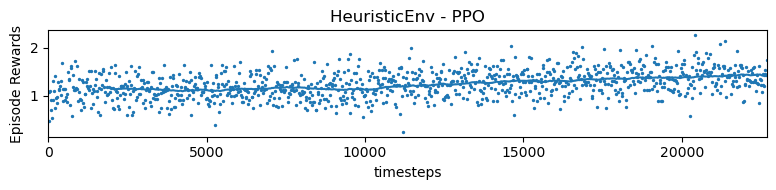

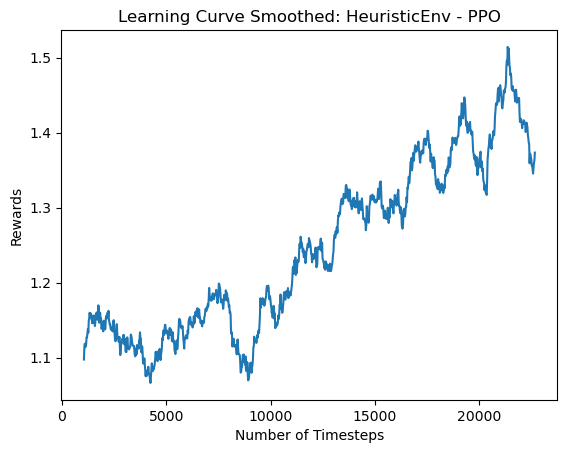

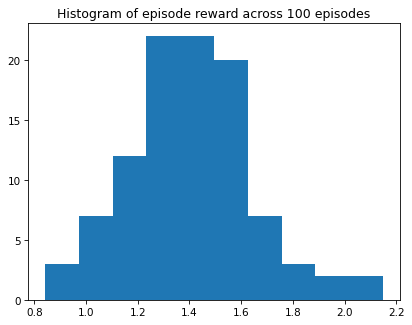

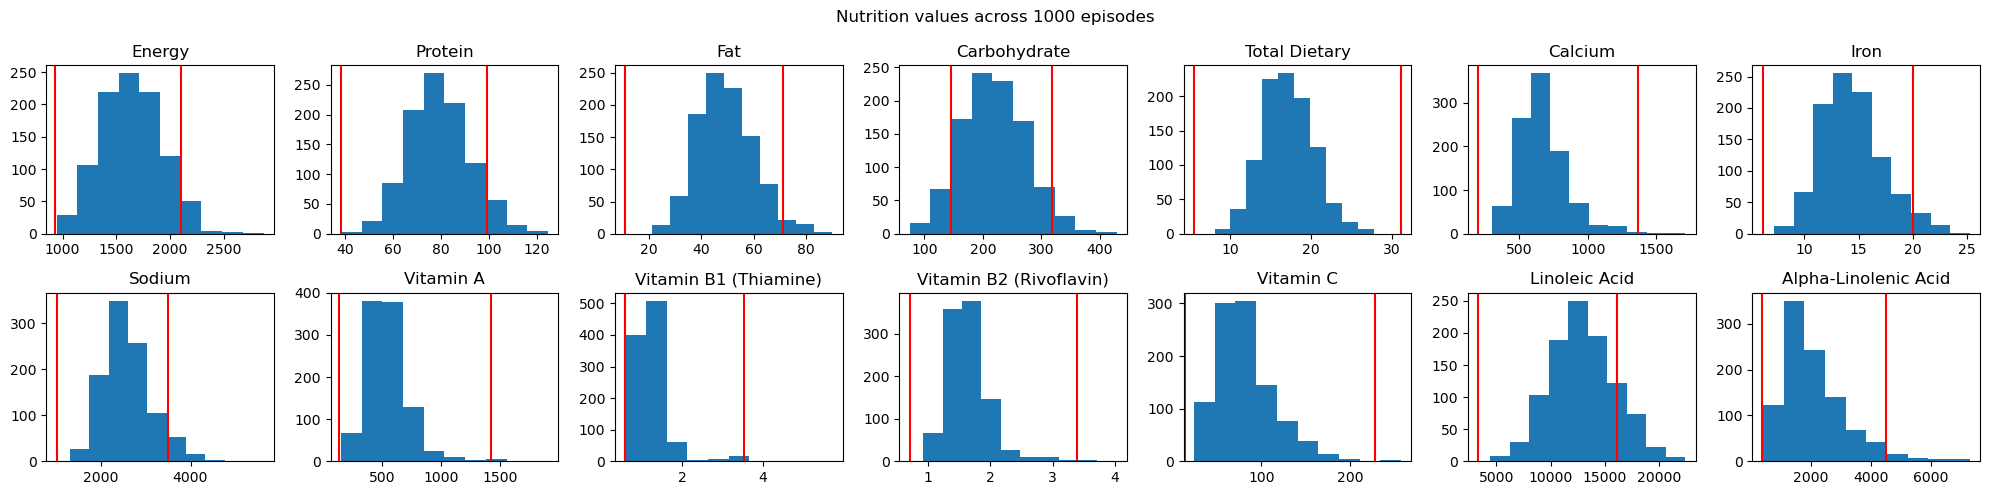

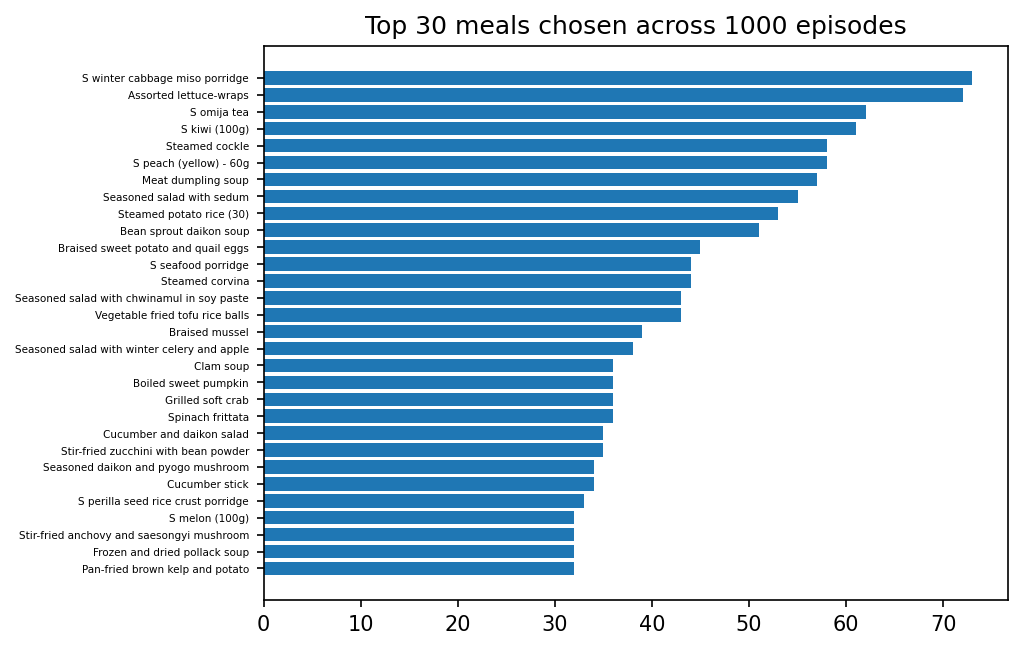

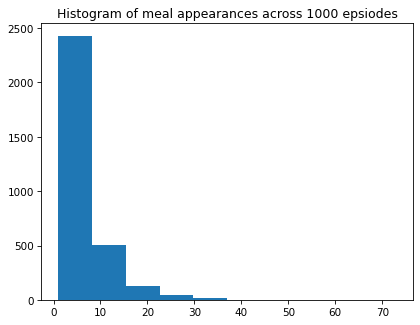

(<stable_baselines3.ppo.ppo.PPO at 0x7fb18924dfa0>,
 <Monitor<HeuristicEnv instance>>)

In [6]:
log_dir = f"./tmp/gym/{time.strftime('%Y%m%d-%H%M%S')}"
os.makedirs(log_dir, exist_ok=False)
print(f'Output stored at: {log_dir}')

heuristic_env.set_reward_weights(
    coef_nutrition_lower=1,
    coef_nutrition_upper=-1,
    coef_sequence_entropy=0,
    coef_repetitions=0,
    coef_overall_entropy=0,
    coef_carbon=5
)
run_with_learning_algorithm(PPO, heuristic_env, 20000, log_dir, num_meals=21, seed=0)

# TODO: titles and narration needed

Using cpu device
Wrapping the env in a DummyVecEnv.
Initial Results
Step: 21
Chosen Meal: S seaweed veggie porridge
Chosen Meal Category: Soup (snack)
Meal History: ['Pan-fried cuttlefish and kimchi' 'Perilla seed tofu soup'
 'Braised king oyster mushroom' 'Seasoned winter cabbage in soy paste'
 'Veggie rice ball' 'Mussel daikon soup'
 'Stir-fried beef brisket and cabbage'
 'Mixed buckwheat noodles with sprouts' 'Beef rice noodles'
 'Fruit salad (yoghurt dressing)' 'S sweet potato tofu porridge'
 'Curried rice with saesongyi mushroom'
 'Stir-fried chicken breast and perilla leaves' 'Cucumber omelette'
 'Fried tofu cabbage soup' 'S watermelon punch' 'S cabbage porridge'
 'Cabbage salad (strawberry dressing)'
 'Stir-fried tuna and kimchi with rice' 'Stir-fried pork chops'
 'S seaweed veggie porridge']
Category History: ['Pancake' 'Soup' 'Braised' 'Salad' 'Combo meal rice' 'Soup' 'Stir-fried'
 'Noodles' 'Noodles' 'Salad' 'Soup (snack)' 'Combo meal rice' 'Stir-fried'
 'Stir-fried' 'Soup' '

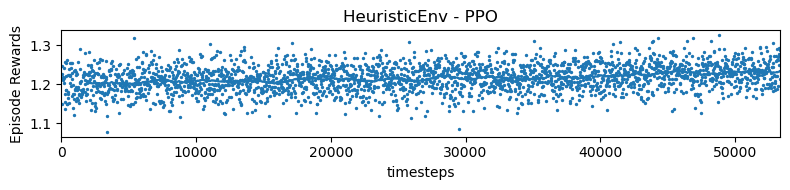

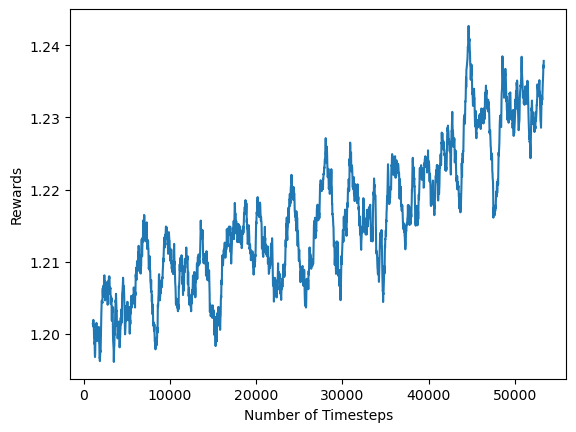

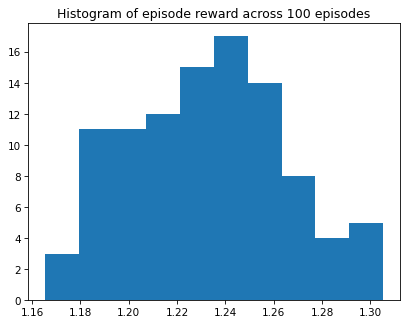

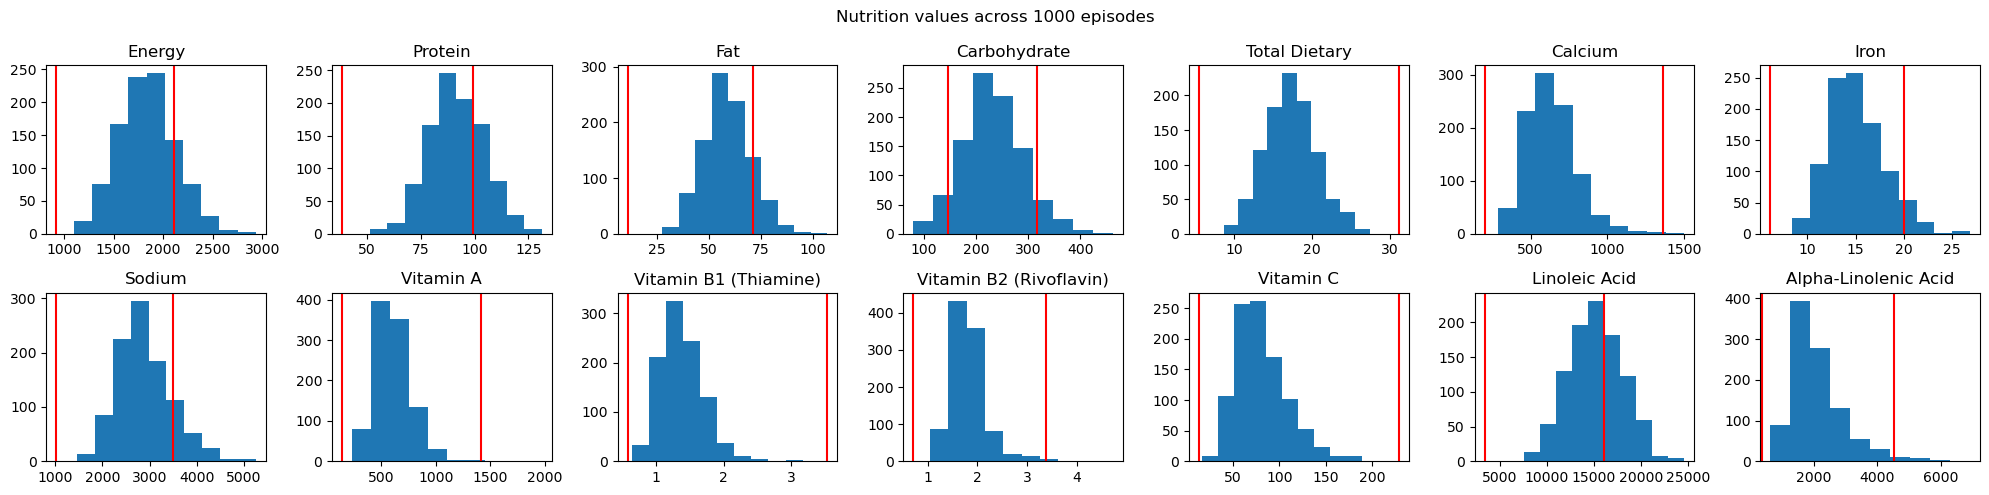

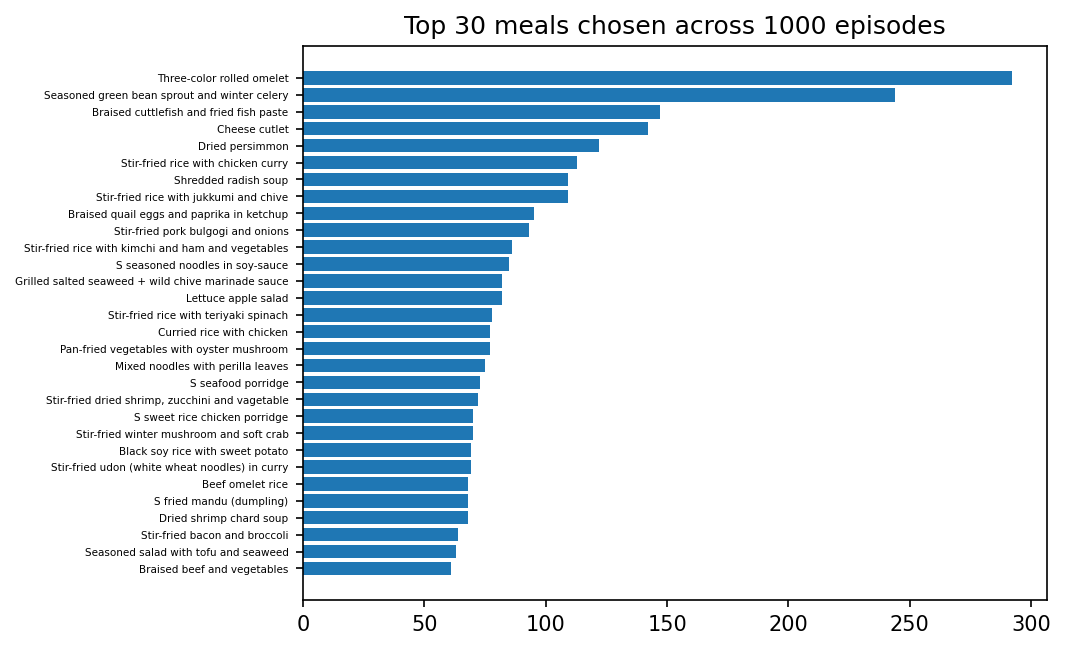

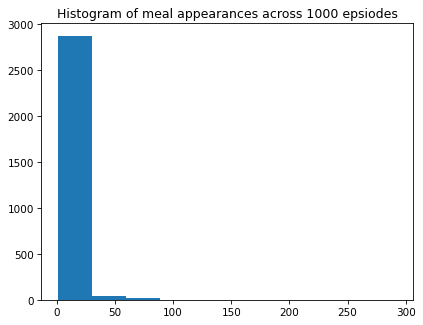

(<stable_baselines3.ppo.ppo.PPO at 0x7f81d8a01280>,
 <Monitor<HeuristicEnv instance>>)

In [5]:
log_dir = f"./tmp/gym/{time.strftime('%Y%m%d-%H%M%S')}"
os.makedirs(log_dir, exist_ok=False)

heuristic_env.set_reward_weights(
    coef_nutrition_lower=1,
    coef_nutrition_upper=-1,
    coef_sequence_entropy=0,
    coef_repetitions=0,
    coef_overall_entropy=1
)
run_with_learning_algorithm(PPO, heuristic_env, 50000, log_dir, num_meals=21, seed=0)

Using cpu device
Wrapping the env in a DummyVecEnv.
Initial Results
Step: 21
Chosen Meal: S seaweed veggie porridge
Chosen Meal Category: Soup (snack)
Meal History: ['Pan-fried cuttlefish and kimchi' 'Perilla seed tofu soup'
 'Braised king oyster mushroom' 'Seasoned winter cabbage in soy paste'
 'Veggie rice ball' 'Mussel daikon soup'
 'Stir-fried beef brisket and cabbage'
 'Mixed buckwheat noodles with sprouts' 'Beef rice noodles'
 'Fruit salad (yoghurt dressing)' 'S sweet potato tofu porridge'
 'Curried rice with saesongyi mushroom'
 'Stir-fried chicken breast and perilla leaves' 'Cucumber omelette'
 'Fried tofu cabbage soup' 'S watermelon punch' 'S cabbage porridge'
 'Cabbage salad (strawberry dressing)'
 'Stir-fried tuna and kimchi with rice' 'Stir-fried pork chops'
 'S seaweed veggie porridge']
Category History: ['Pancake' 'Soup' 'Braised' 'Salad' 'Combo meal rice' 'Soup' 'Stir-fried'
 'Noodles' 'Noodles' 'Salad' 'Soup (snack)' 'Combo meal rice' 'Stir-fried'
 'Stir-fried' 'Soup' '

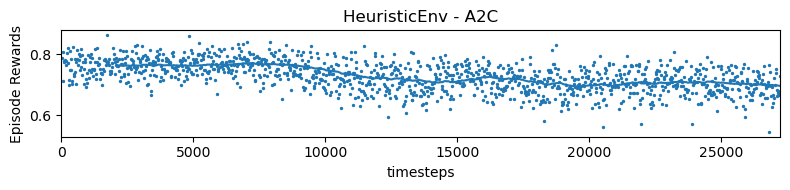

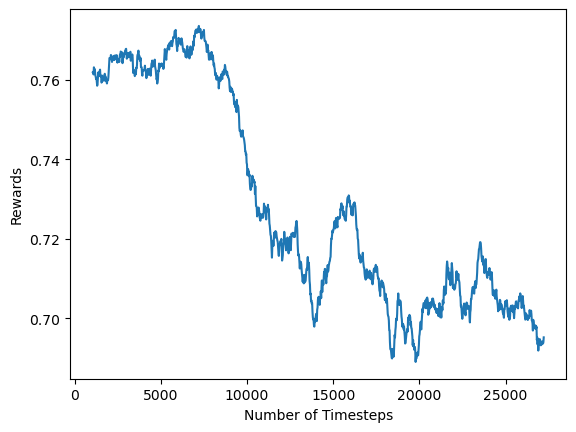

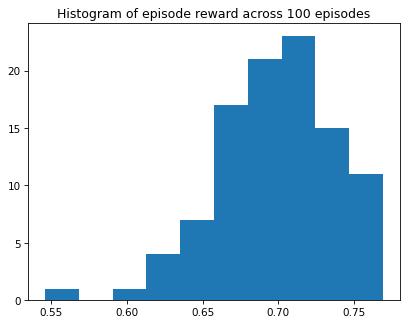

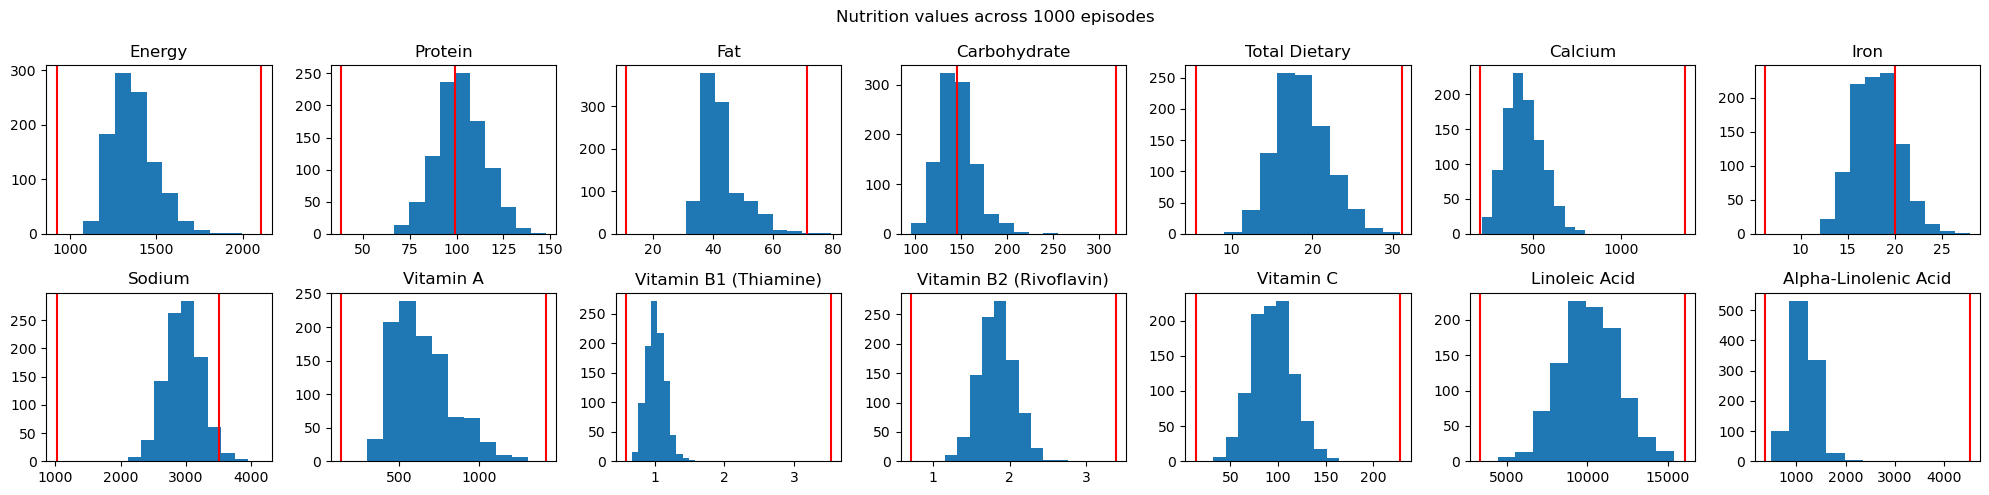

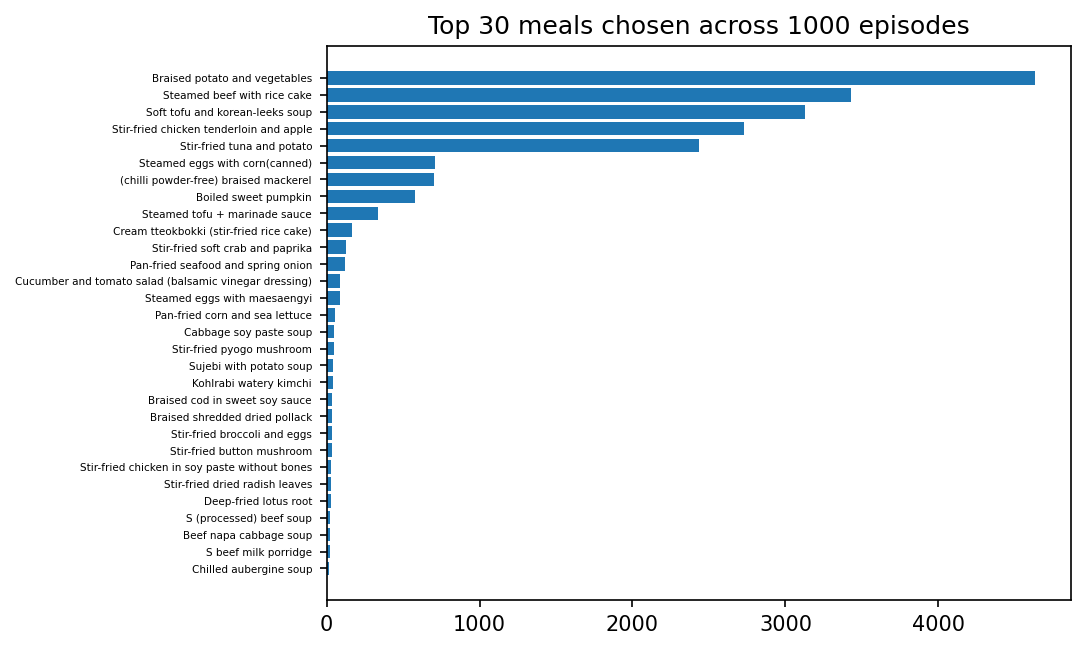

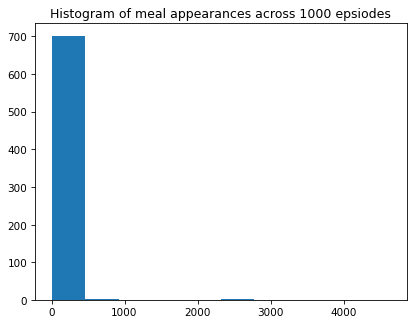

(<stable_baselines3.a2c.a2c.A2C at 0x7f8d13d20e80>,
 <Monitor<HeuristicEnv instance>>)

In [6]:
log_dir = f"./tmp/gym/{time.strftime('%Y%m%d-%H%M%S')}"
os.makedirs(log_dir, exist_ok=False)

heuristic_env.set_reward_weights(
    coef_nutrition_lower=1,
    coef_nutrition_upper=-1,
    coef_sequence_entropy=0,
    coef_repetitions=-1,
    coef_overall_entropy=0
)
run_with_learning_algorithm(A2C, heuristic_env, 25000, log_dir, num_meals=21, seed=0)

Using cpu device
Wrapping the env in a DummyVecEnv.
Initial Results
Step: 21
Chosen Meal: Stir-fried smoked duck
Chosen Meal Category: Stir-fried
Meal History: ['Stir-fried boneless pork and kimchi'
 'Stir-fried boneless pork and kimchi'
 'Stir-fried boneless pork and kimchi'
 'Stir-fried boneless pork and kimchi'
 'Stir-fried boneless pork and kimchi'
 'Stir-fried boneless pork and kimchi'
 'Stir-fried boneless pork and kimchi' 'Sedum fruit salad'
 'Tomato cheese mash' 'Tomato cheese mash' 'Tomato cheese mash'
 'Tomato cheese mash' 'Tomato cheese mash' 'Stir-fried smoked duck'
 'Stir-fried smoked duck' 'Stir-fried smoked duck'
 'Stir-fried smoked duck' 'Stir-fried smoked duck'
 'Stir-fried smoked duck' 'Stir-fried smoked duck'
 'Stir-fried smoked duck']
Category History: ['Stir-fried' 'Stir-fried' 'Stir-fried' 'Stir-fried' 'Stir-fried'
 'Stir-fried' 'Stir-fried' 'Salad' 'Salad' 'Salad' 'Salad' 'Salad' 'Salad'
 'Stir-fried' 'Stir-fried' 'Stir-fried' 'Stir-fried' 'Stir-fried'
 'Stir-fri

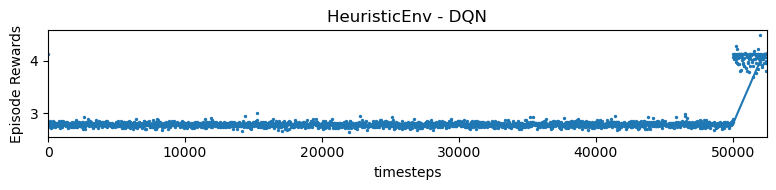

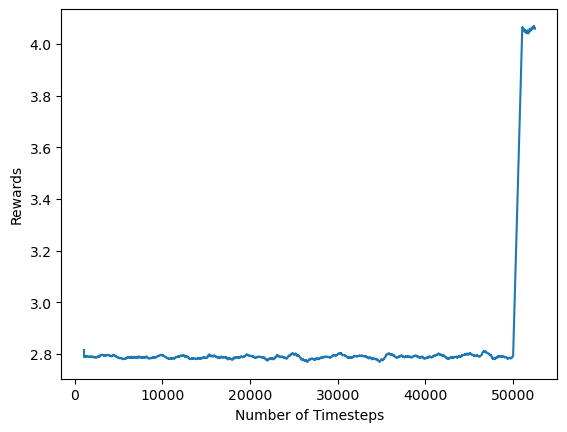

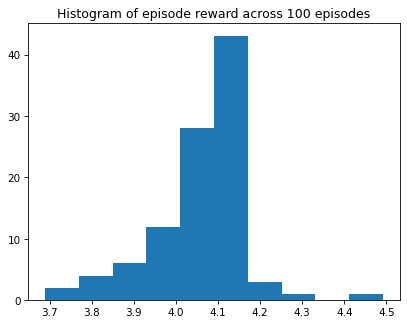

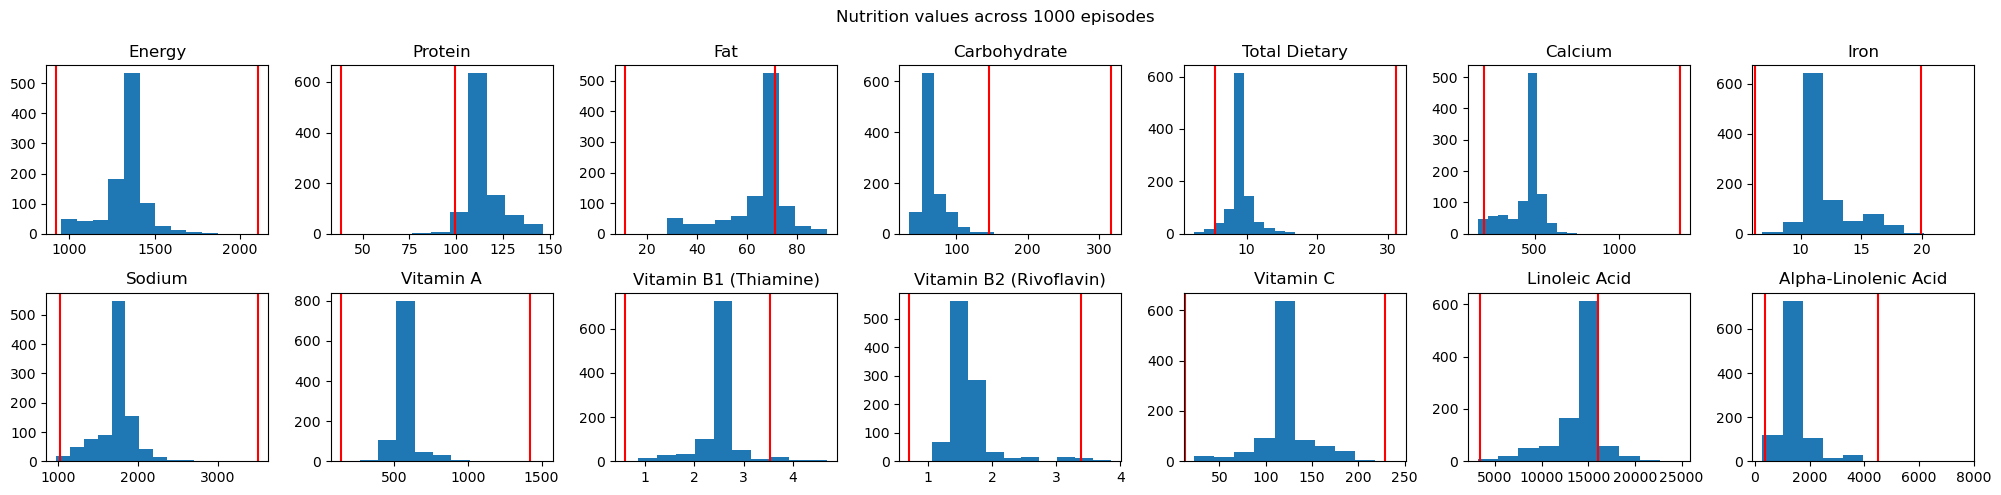

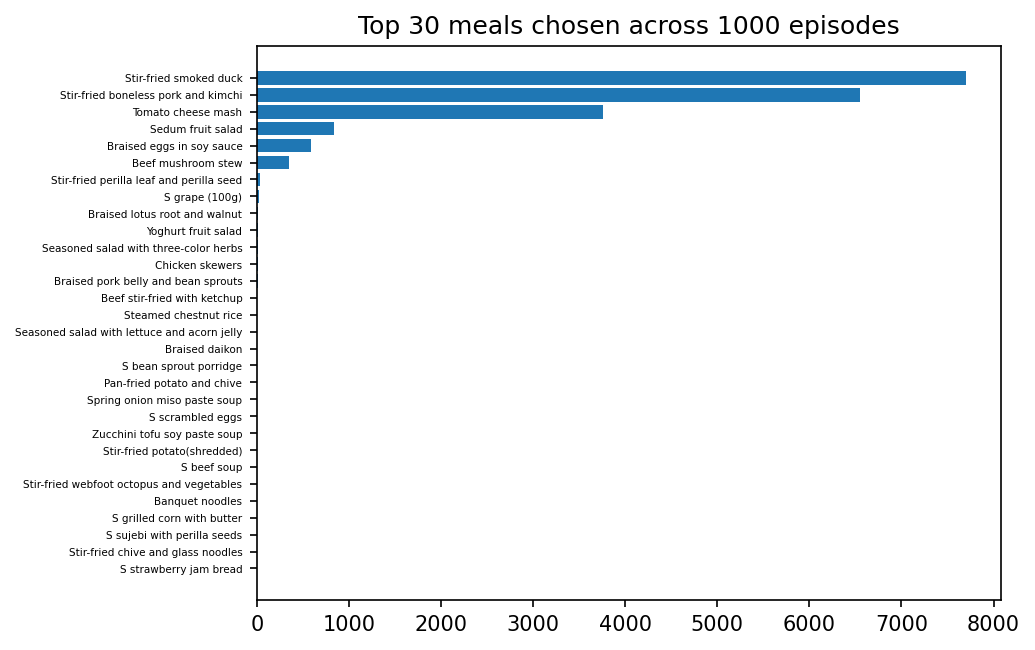

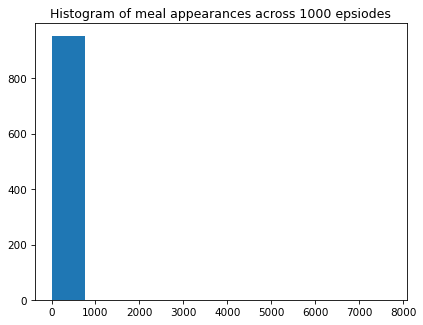

(<stable_baselines3.dqn.dqn.DQN at 0x7f820c106130>,
 <Monitor<HeuristicEnv instance>>)

In [7]:
log_dir = f"./tmp/gym/{time.strftime('%Y%m%d-%H%M%S')}"
os.makedirs(log_dir, exist_ok=False)

heuristic_env.set_reward_weights(
    coef_nutrition_lower=1,
    coef_nutrition_upper=-1,
    coef_sequence_entropy=0,
    coef_repetitions=0,
    coef_overall_entropy=5
)
run_with_learning_algorithm(DQN, heuristic_env, 50000, log_dir, num_meals=21, seed=0)

Using cpu device
Wrapping the env in a DummyVecEnv.
Initial Results
Step: 21
Chosen Meal: S seaweed veggie porridge
Chosen Meal Category: Soup (snack)
Meal History: ['Pan-fried cuttlefish and kimchi' 'Perilla seed tofu soup'
 'Braised king oyster mushroom' 'Seasoned winter cabbage in soy paste'
 'Veggie rice ball' 'Mussel daikon soup'
 'Stir-fried beef brisket and cabbage'
 'Mixed buckwheat noodles with sprouts' 'Beef rice noodles'
 'Fruit salad (yoghurt dressing)' 'S sweet potato tofu porridge'
 'Curried rice with saesongyi mushroom'
 'Stir-fried chicken breast and perilla leaves' 'Cucumber omelette'
 'Fried tofu cabbage soup' 'S watermelon punch' 'S cabbage porridge'
 'Cabbage salad (strawberry dressing)'
 'Stir-fried tuna and kimchi with rice' 'Stir-fried pork chops'
 'S seaweed veggie porridge']
Category History: ['Pancake' 'Soup' 'Braised' 'Salad' 'Combo meal rice' 'Soup' 'Stir-fried'
 'Noodles' 'Noodles' 'Salad' 'Soup (snack)' 'Combo meal rice' 'Stir-fried'
 'Stir-fried' 'Soup' '

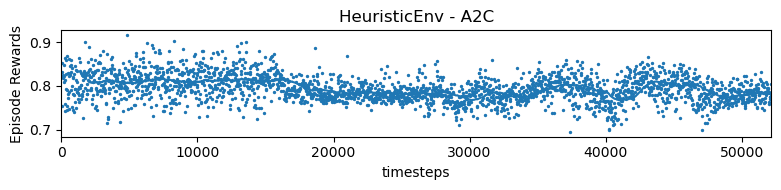

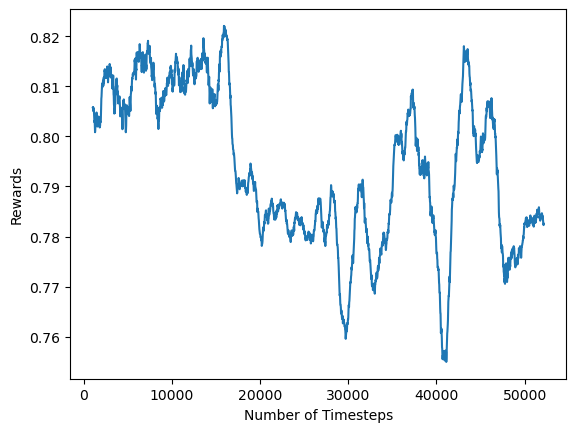

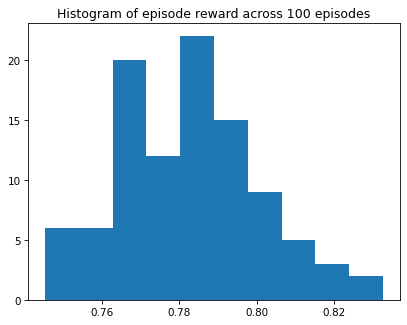

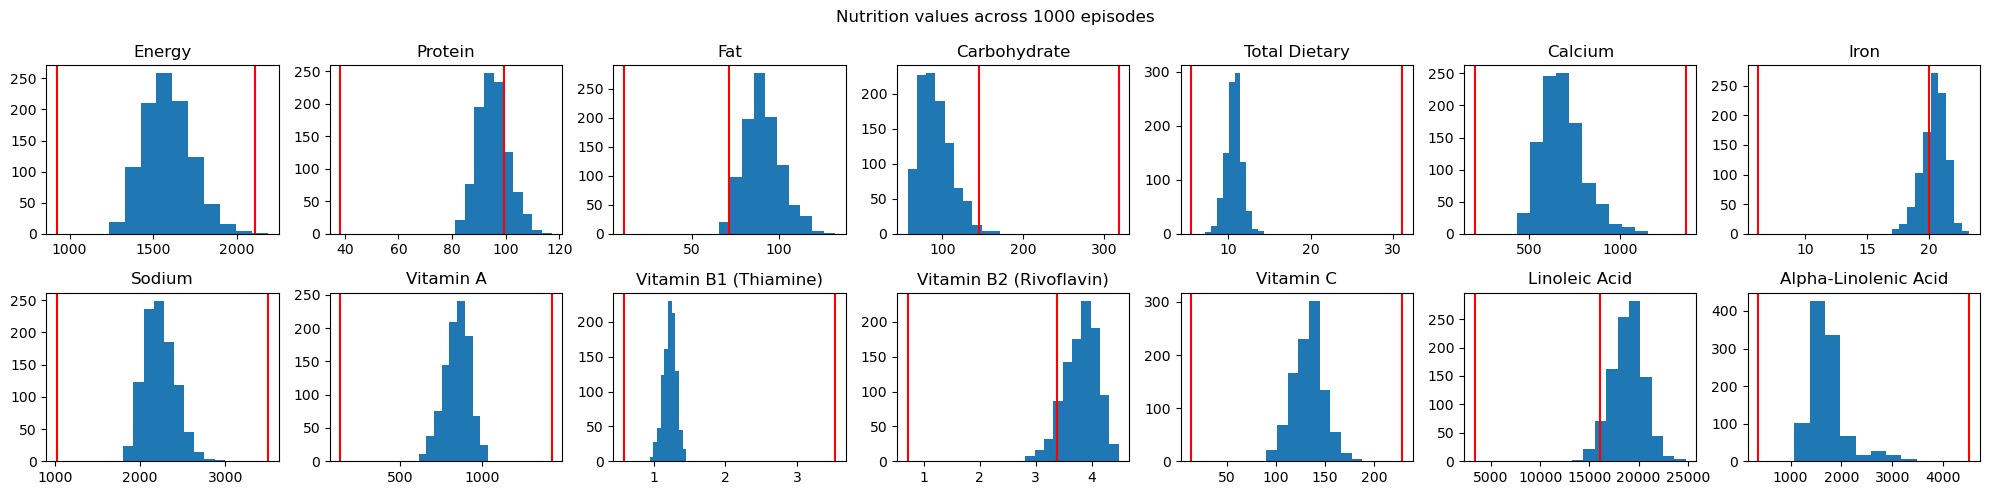

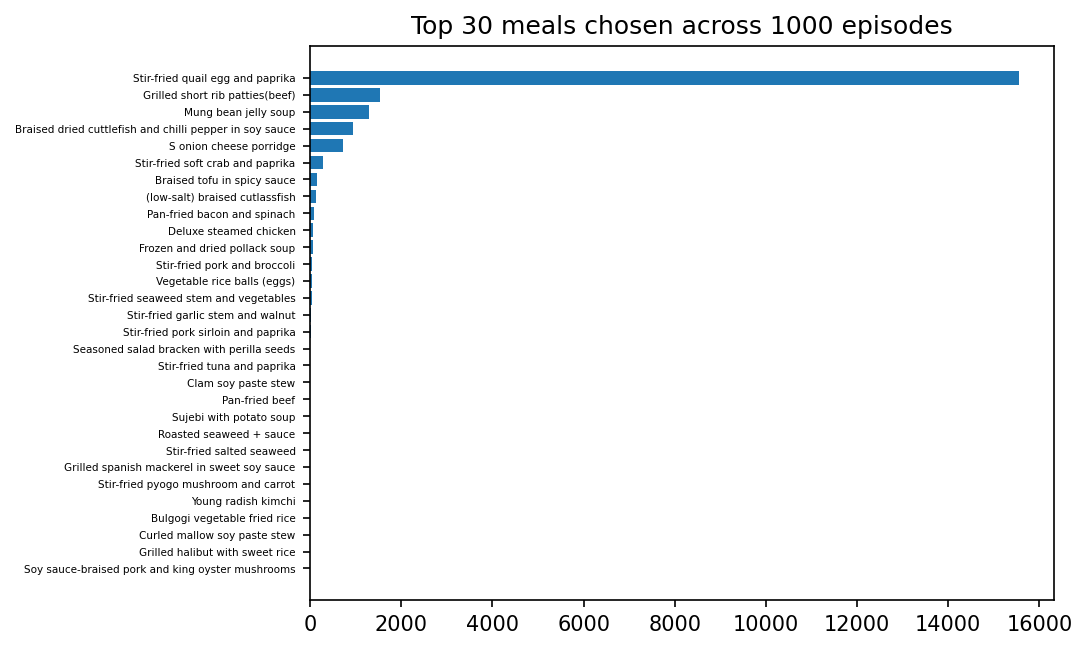

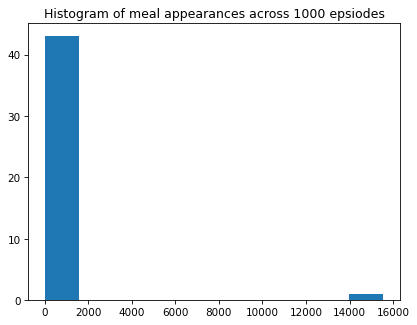

(<stable_baselines3.a2c.a2c.A2C at 0x7f8259d2c520>,
 <Monitor<HeuristicEnv instance>>)

In [10]:
log_dir = f"./tmp/gym/{time.strftime('%Y%m%d-%H%M%S')}"
os.makedirs(log_dir, exist_ok=False)

heuristic_env.set_reward_weights(
    coef_nutrition_lower=1,
    coef_nutrition_upper=-1,
    coef_sequence_entropy=0,
    coef_repetitions=0,
    coef_overall_entropy=0
)
run_with_learning_algorithm(A2C, heuristic_env, 50000, log_dir, num_meals=21, seed=0)

### Test A2C on MaxNutritionEnv

In [11]:
log_dir = f"./tmp/gym/{time.strftime('%Y%m%d-%H%M%S')}"
os.makedirs(log_dir, exist_ok=False)

run_with_learning_algorithm(A2C, max_env, 50000, log_dir, num_meals=21, seed=0)

Using cpu device
Wrapping the env in a DummyVecEnv.
Initial Results
Step: 21
Chosen Meal: S seaweed veggie porridge
Chosen Meal Category: Soup (snack)
Meal History: ['Pan-fried cuttlefish and kimchi' 'Perilla seed tofu soup'
 'Braised king oyster mushroom' 'Seasoned winter cabbage in soy paste'
 'Veggie rice ball' 'Mussel daikon soup'
 'Stir-fried beef brisket and cabbage'
 'Mixed buckwheat noodles with sprouts' 'Beef rice noodles'
 'Fruit salad (yoghurt dressing)' 'S sweet potato tofu porridge'
 'Curried rice with saesongyi mushroom'
 'Stir-fried chicken breast and perilla leaves' 'Cucumber omelette'
 'Fried tofu cabbage soup' 'S watermelon punch' 'S cabbage porridge'
 'Cabbage salad (strawberry dressing)'
 'Stir-fried tuna and kimchi with rice' 'Stir-fried pork chops'
 'S seaweed veggie porridge']
Category History: ['Pancake' 'Soup' 'Braised' 'Salad' 'Combo meal rice' 'Soup' 'Stir-fried'
 'Noodles' 'Noodles' 'Salad' 'Soup (snack)' 'Combo meal rice' 'Stir-fried'
 'Stir-fried' 'Soup' '

KeyboardInterrupt: 

### Test DQN

Using cpu device
Wrapping the env in a DummyVecEnv.
Initial Results
Step: 21
Chosen Meal: Stir-fried smoked duck
Chosen Meal Category: Stir-fried
Meal History: ['Stir-fried boneless pork and kimchi'
 'Stir-fried boneless pork and kimchi'
 'Stir-fried boneless pork and kimchi'
 'Stir-fried boneless pork and kimchi'
 'Stir-fried boneless pork and kimchi'
 'Stir-fried boneless pork and kimchi'
 'Stir-fried boneless pork and kimchi' 'Sedum fruit salad'
 'Tomato cheese mash' 'Tomato cheese mash' 'Tomato cheese mash'
 'Tomato cheese mash' 'Tomato cheese mash' 'Stir-fried smoked duck'
 'Stir-fried smoked duck' 'Stir-fried smoked duck'
 'Stir-fried smoked duck' 'Stir-fried smoked duck'
 'Stir-fried smoked duck' 'Stir-fried smoked duck'
 'Stir-fried smoked duck']
Category History: ['Stir-fried' 'Stir-fried' 'Stir-fried' 'Stir-fried' 'Stir-fried'
 'Stir-fried' 'Stir-fried' 'Salad' 'Salad' 'Salad' 'Salad' 'Salad' 'Salad'
 'Stir-fried' 'Stir-fried' 'Stir-fried' 'Stir-fried' 'Stir-fried'
 'Stir-fri

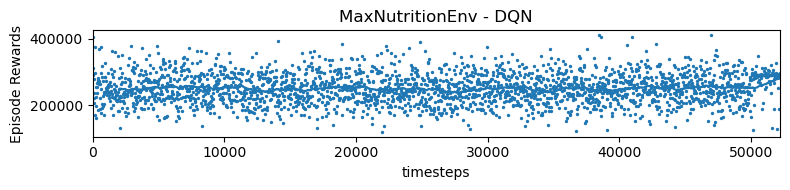

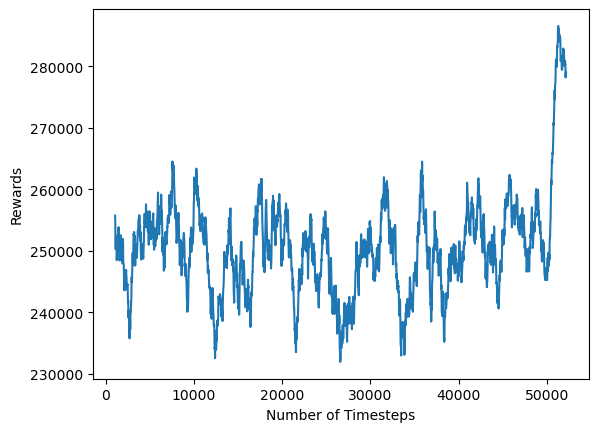

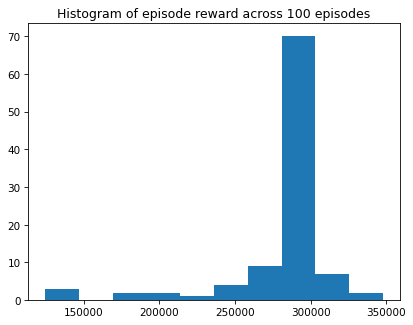

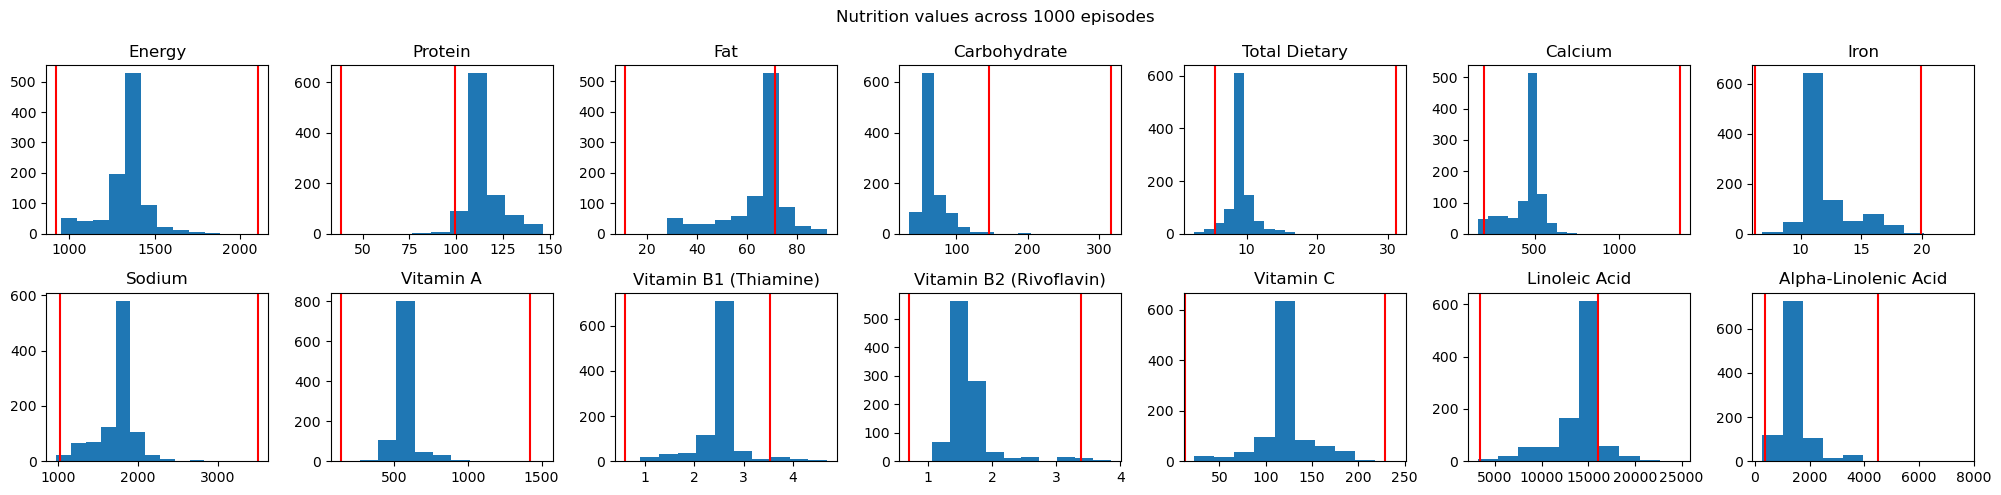

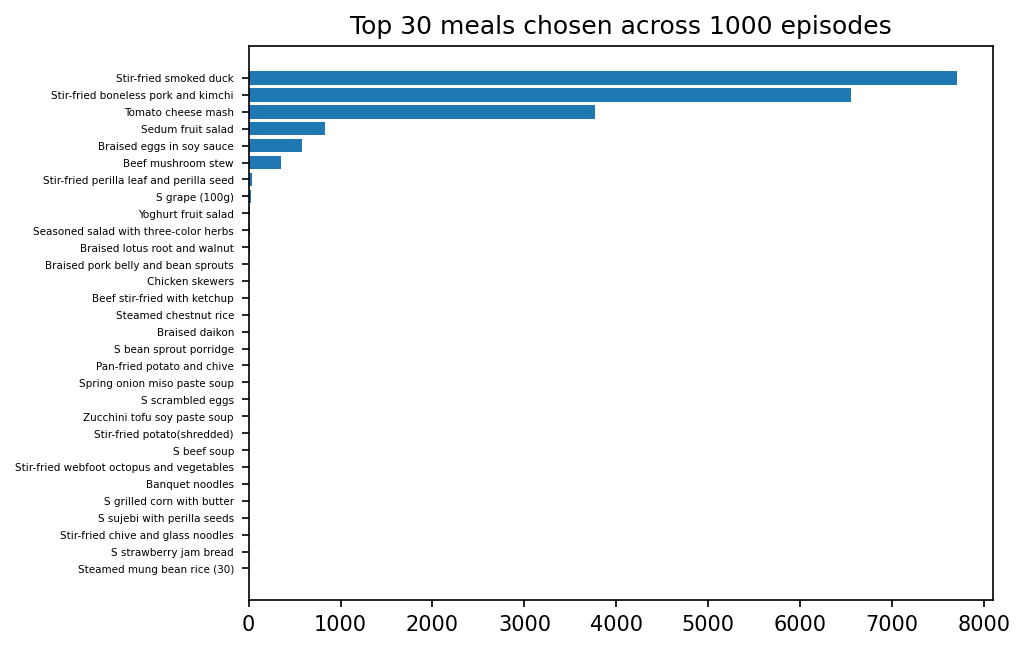

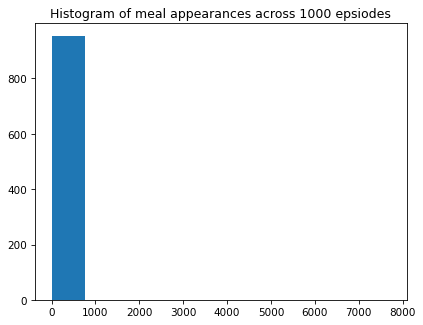

(<stable_baselines3.dqn.dqn.DQN at 0x7f81fb138ee0>,
 <Monitor<MaxNutritionEnv instance>>)

In [9]:
log_dir = f"./tmp/gym/{time.strftime('%Y%m%d-%H%M%S')}"
os.makedirs(log_dir, exist_ok=False)

run_with_learning_algorithm(DQN, max_env, 50000, log_dir, num_meals=21, seed=0)